# Statistical Analysis <a id='stats'></a>

[Data quality](#qa) <br>
[Behavioral results](#beh) <br>
[Brain graph metrics](#graph) <br>
[Mean FC](#fc) <br>
[Regression analyses](#reg) <br>

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg

pd.set_option("display.precision", 3)
sns.set_palette('Set1')

homeDir = os.path.expanduser("~")
homeDir

'/Users/mcmahonmc'

In [2]:
df = pd.read_csv('./data/03_fc_data.csv')
df = df.set_index('subject')
print(df.shape)


modVars = [col for col in df.columns if col.startswith('q_')]
pcVars = [i for i in df.columns if 'pc_' in i and 'dmn_fpn' not in i]
fcVars = [col for col in df.columns if 'fc' in col]
memVars = [col for col in df.columns if 'acc_' in col or 'rt_c_' in col]
edgeVars = [col for col in df if col.startswith('net')]
pcaVars = ['C1', 'C2', 'C3']
sleepVars = ['actamp', 'actphi', 'sleep_time_mean_sleep', 'total_ac_mean_active', 'efficiency_mean_sleep']

df.head()

(130, 92)


/usr/local/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,Group,GroupBin,age,sex,acc_learning,rt_c_learning,acc_learning_log,acc_test_mean,rt_c_test_mean,acc_test_std,...,net_int_edge_19,net_int_edge_20,net_int_edge_21,net_int_edge_22,net_int_edge_23,net_int_edge_24,net_int_mean,C1,C2,C3
subject,,,,,,,,,,,,,,,,,,,,,
30003,Young Adults,0,22.0,Female,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30004,Young Adults,0,27.0,Female,0.917,1263.611,-0.038,0.972,11297.879,0.048,...,0.902,0.518,0.265,0.079,0.082,0.034,0.166,0.168,-0.199,-0.113
30008,Young Adults,0,18.0,Female,0.944,1674.861,-0.025,0.944,11504.639,0.048,...,0.350,-0.051,0.715,0.176,0.100,0.201,0.185,0.020,0.117,-0.165
30009,Young Adults,0,25.0,Female,0.972,1568.694,-0.012,0.972,11405.333,0.048,...,0.247,0.266,0.087,0.601,0.353,0.064,0.096,0.975,-0.306,0.100
30012,Young Adults,0,30.0,Male,0.917,2146.417,-0.038,0.806,11539.750,0.127,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820,-0.199,-0.186


## Data quality <a id='qa'></a>

In [3]:
print(df.shape)
df = df.dropna(subset=['acc_test_mean'])
print(df.shape)
df = df[(df['acc_learning'] > 0.33)]
print(df.shape)
df = df[(df['acc_test_mean'] > 0.56)]
print(df.shape)
df = df[(~df['C1'].isna())] # these are participants with poor quality actigraphy data, determined from ML project
print(df.shape)

(130, 92)
(114, 92)
(112, 92)
(100, 92)
(92, 92)


In [4]:
df[df['C1'].isna()][['actamp', 'C1']]

,actamp,C1
subject,,


In [5]:
df.isna().sum()

Group               0
GroupBin            0
age                 0
sex                 0
acc_learning        0
                   ..
net_int_edge_24    23
net_int_mean       23
C1                  0
C2                  0
C3                  0
Length: 92, dtype: int64

In [6]:
df[df['Group'] == 'Older Adults'].isna().sum()

Group               0
GroupBin            0
age                 0
sex                 0
acc_learning        0
                   ..
net_int_edge_24    19
net_int_mean       19
C1                  0
C2                  0
C3                  0
Length: 92, dtype: int64

In [131]:
print(df[df['Group'] == 'Young Adults'].isna().sum()['q_dmnfpn_cue'])
print(df[df['Group'] == 'Older Adults'].isna().sum()['q_dmnfpn_cue'])

6
19


In [7]:
ya = df[df['Group'] == 'Young Adults']
ya = ya.fillna(ya.mean())

oa = df[df['Group'] == 'Older Adults']
oa = oa.fillna(oa.mean())

dfFill = pd.concat((ya, oa))
print(df.shape)
dfFill.head()

(92, 92)


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_50160/852004413.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ya = ya.fillna(ya.mean())
/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_50160/852004413.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  oa = oa.fillna(oa.mean())


,Group,GroupBin,age,sex,acc_learning,rt_c_learning,acc_learning_log,acc_test_mean,rt_c_test_mean,acc_test_std,...,net_int_edge_19,net_int_edge_20,net_int_edge_21,net_int_edge_22,net_int_edge_23,net_int_edge_24,net_int_mean,C1,C2,C3
subject,,,,,,,,,,,,,,,,,,,,,
30004,Young Adults,0,27.0,Female,0.917,1263.611,-0.038,0.972,11297.879,0.048,...,0.902,0.518,0.265,0.079,0.082,0.034,0.166,0.168,-0.199,-0.113
30008,Young Adults,0,18.0,Female,0.944,1674.861,-0.025,0.944,11504.639,0.048,...,0.350,-0.051,0.715,0.176,0.100,0.201,0.185,0.020,0.117,-0.165
30009,Young Adults,0,25.0,Female,0.972,1568.694,-0.012,0.972,11405.333,0.048,...,0.247,0.266,0.087,0.601,0.353,0.064,0.096,0.975,-0.306,0.100
30012,Young Adults,0,30.0,Male,0.917,2146.417,-0.038,0.806,11539.750,0.127,...,0.461,0.281,0.282,0.228,0.342,0.207,0.190,0.820,-0.199,-0.186
30015,Young Adults,0,26.0,Male,0.972,2064.250,-0.012,0.889,11690.604,0.048,...,0.170,0.281,-0.048,0.396,0.034,0.199,0.149,0.160,-0.288,0.026


In [8]:
df.acc_test_mean.min()

0.638888888888889

## Behavioral results <a id='beh'></a>

### Task

In [9]:
behtable = df[['Group'] + [c for c in memVars if 'learning' in c or 'mean' in c]].groupby('Group').describe().T.round(3)[['Young Adults', 'Older Adults']]
behtable.to_latex('./results/behresults.tex', index=True)
behtable

Group                    Young Adults  Older Adults
acc_learning      count        47.000        45.000
                  mean          0.909         0.838
                  std           0.136         0.143
                  min           0.333         0.417
                  25%           0.875         0.806
                  50%           0.944         0.889
                  75%           1.000         0.944
                  max           1.000         1.000
rt_c_learning     count        47.000        45.000
                  mean       1828.900      2569.343
                  std         499.434      1022.356
                  min         735.417       396.750
                  25%        1468.056      1888.500
                  50%        1794.611      2383.222
                  75%        2117.639      3097.333
                  max        3693.194      6417.333
acc_learning_log  count        47.000        45.000
                  mean         -0.049        -0.084
                  std           0.089         0.086
                  min          -0.477        -0.380
                  25%          -0.058        -0.094
                  50%          -0.025        -0.051
                  75%           0.000        -0.025
                  max           0.000         0.000
acc_test_mean     count        47.000        45.000
                  mean          0.908         0.848
                  std           0.099         0.096
                  min           0.667         0.639
                  25%           0.875         0.778
                  50%           0.944         0.861
                  75%           0.972         0.917
                  max           1.000         1.000
rt_c_test_mean    count        47.000        45.000
                  mean      11474.970     11789.461
                  std         197.735       239.543
                  min       11063.972     11210.629
                  25%       11325.345     11604.321
                  50%       11481.222     11803.336
                  75%       11577.420     11935.972
                  max       11955.700     12314.625
acc_test_mean_log count        47.000        45.000
                  mean         -0.045        -0.075
                  std           0.051         0.050
                  min          -0.176        -0.195
                  25%          -0.058        -0.109
                  50%          -0.025        -0.065
                  75%          -0.012        -0.038
                  max           0.000         0.000

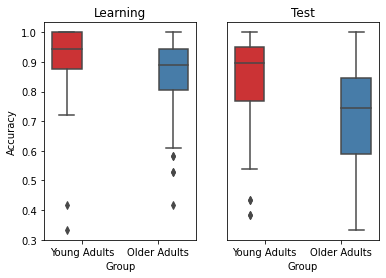

In [10]:
sns.set_palette('Set1')
fig, axes = plt.subplots(1,2)

sns.boxplot(data=df, x='Group', y='acc_learning', hue='Group', ax=axes[0]).set(title='Learning');
axes[0].set_ylabel('Accuracy'); axes[0].get_legend().remove()

sns.boxplot(data=df, x='Group', y='acc_test_mean', hue='Group', ax=axes[1]).set(title='Test');
plt.ylabel(''); axes[1].yaxis.set_visible(False); axes[1].get_legend().remove()
plt.savefig('./results/accuracy.png', dpi=300)

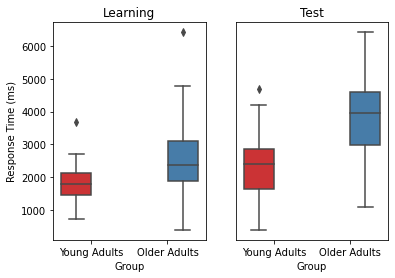

In [11]:
sns.set_palette('Set1')
fig, axes = plt.subplots(1,2)

sns.boxplot(data=df, x='Group', y='rt_c_learning', hue='Group', ax=axes[0]).set(title='Learning');
axes[0].set_ylabel('Response Time (ms)'); axes[0].get_legend().remove()

sns.boxplot(data=df, x='Group', y='rt_c_test_mean', hue='Group', ax=axes[1]).set(title='Test');
plt.ylabel(''); axes[1].yaxis.set_visible(False); axes[1].get_legend().remove()
plt.savefig('./results/rtc.png', dpi=300)

In [12]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['acc_learning'].dropna(), df[df['Group'] == "Older Adults"]['acc_learning'].dropna())

Ttest_indResult(statistic=2.4292642562573286, pvalue=0.017116264267879055)

In [13]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['rt_c_learning'].dropna(), df[df['Group'] == "Older Adults"]['rt_c_learning'].dropna())

Ttest_indResult(statistic=-4.4430249846017436, pvalue=2.5184729093114565e-05)

In [14]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['acc_test_mean'].dropna(), df[df['Group'] == "Older Adults"]['acc_test_mean'].dropna())

Ttest_indResult(statistic=2.920635265798123, pvalue=0.00441453041139037)

In [15]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['rt_c_test_mean'].dropna(), df[df['Group'] == "Older Adults"]['rt_c_test_mean'].dropna())

Ttest_indResult(statistic=-6.879887785097898, pvalue=7.716462241451917e-10)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='acc_learning_log', ylabel='Density'>

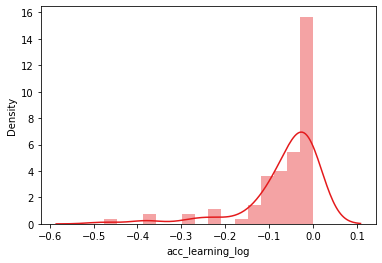

In [16]:
sns.distplot(df['acc_learning_log'].dropna())

### RAR/Sleep

In [17]:
stats.ttest_ind(df[df['sex'] == "Male"]['actamp'].dropna(), df[df['sex'] == "Female"]['actamp'].dropna())

Ttest_indResult(statistic=-1.5320869505027657, pvalue=0.1290882357532344)

In [18]:
stats.ttest_ind(df[df['sex'] == "Male"]['actphi'].dropna(), df[df['sex'] == "Female"]['actphi'].dropna())

Ttest_indResult(statistic=0.778214470839726, pvalue=0.4384837247479)

In [19]:
pg.corr(df['actamp'], df['sleep_time_mean_sleep'])

,n,r,CI95%,p-val,BF10,power
pearson,90,0.032,"[-0.18, 0.24]",0.768,0.137,0.06


In [20]:
pg.corr(df['actamp'], df['efficiency_mean_sleep'])

,n,r,CI95%,p-val,BF10,power
pearson,90,0.256,"[0.05, 0.44]",0.015,2.431,0.689


In [21]:
pg.corr(df['actamp'], df['total_ac_mean_active'])

,n,r,CI95%,p-val,BF10,power
pearson,90,0.309,"[0.11, 0.48]",0.003,9.861,0.849


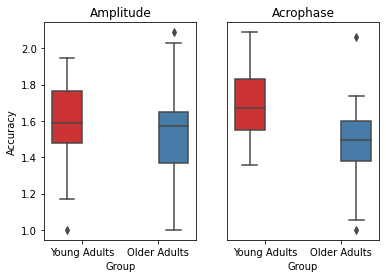

In [22]:
sns.set_palette('Set1')
fig, axes = plt.subplots(1,2)

sns.boxplot(data=df, x='Group', y='actamp', hue='Group', ax=axes[0]).set(title='Amplitude');
axes[0].set_ylabel('Accuracy'); axes[0].get_legend().remove()

sns.boxplot(data=df, x='Group', y='actphi', hue='Group', ax=axes[1]).set(title='Acrophase');
plt.ylabel(''); axes[1].yaxis.set_visible(False); axes[1].get_legend().remove()
plt.savefig('./results/rar.png', dpi=300)

In [23]:
df[['actamp', 'actphi', 'sleep_time_mean_sleep', 'total_ac_mean_active', 'efficiency_mean_sleep', 'Group']].groupby('Group').mean().T

Group,Older Adults,Young Adults
actamp,1.538,1.607
actphi,14.776,16.393
sleep_time_mean_sleep,403.277,387.110
total_ac_mean_active,253872.048,299137.059
efficiency_mean_sleep,79.711,81.869


In [24]:
df[['actamp', 'actphi', 'sleep_time_mean_sleep', 'total_ac_mean_active', 'efficiency_mean_sleep', 'Group']].groupby('Group').std().T

Group,Older Adults,Young Adults
actamp,0.257,0.214
actphi,1.473,1.443
sleep_time_mean_sleep,84.328,60.830
total_ac_mean_active,90381.542,108696.378
efficiency_mean_sleep,8.934,6.346


In [25]:
var='actamp'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=1.3707319248640069, pvalue=0.17394466654697496)

In [26]:
var='actphi'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=5.32174180213774, pvalue=7.470047543986186e-07)

In [27]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['sleep_time_mean_sleep'].dropna(), df[df['Group'] == "Older Adults"]['sleep_time_mean_sleep'].dropna())


Ttest_indResult(statistic=-1.057969638069928, pvalue=0.2929006654456793)

In [28]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['total_ac_mean_active'].dropna(), df[df['Group'] == "Older Adults"]['total_ac_mean_active'].dropna())



Ttest_indResult(statistic=2.1668159932733366, pvalue=0.03289035825777023)

In [29]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['efficiency_mean_sleep'].dropna(), df[df['Group'] == "Older Adults"]['efficiency_mean_sleep'].dropna())

Ttest_indResult(statistic=1.3405716550001108, pvalue=0.1834336688543481)

## Global brain network metrics <a id='graph'></a>

In [30]:
df[['q_dmnfpn_cue', 'q_dmnfpn_rest', 'pc_dmnfpn_cue', 'q_global_cue', 'q_global_rest', 'pc_global_cue', 'Group']].groupby('Group').mean().T

Group,Older Adults,Young Adults
q_dmnfpn_cue,0.140,0.148
q_dmnfpn_rest,0.143,0.117
pc_dmnfpn_cue,0.216,0.184
q_global_cue,0.305,0.365
q_global_rest,0.368,0.371
pc_global_cue,0.424,0.420


In [31]:
df[['Group'] + fcVars].groupby('Group').mean().T

Group,Older Adults,Young Adults
hc_dmn_fc,0.235,0.193
hc_fpn_fc,0.189,0.084
dmn_fpn_fc,0.284,0.212
dmn_fc,0.362,0.331
fpn_fc,0.471,0.428


In [32]:
var = 'hc_dmn_fc'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=-1.228722719932403, pvalue=0.22347415304733245)

In [33]:
var = 'hc_fpn_fc'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=-2.834630429993259, pvalue=0.006058605627304794)

In [34]:
var = 'dmn_fpn_fc'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=-2.2789881057966888, pvalue=0.025860029373125606)

In [35]:
var = 'dmn_fc'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=-1.183753934753337, pvalue=0.24069337410795175)

In [36]:
var = 'fpn_fc'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=-1.3957163208392434, pvalue=0.16740828385144596)

In [37]:

stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_dmnfpn_rest'].dropna(), df[df['Group'] == "Older Adults"]['q_dmnfpn_rest'].dropna())

Ttest_indResult(statistic=-1.9882402575946352, pvalue=0.05127751950797871)

In [38]:

stats.ttest_ind(df[df['Group'] == "Young Adults"]['pc_dmnfpn_cue'].dropna(), df[df['Group'] == "Older Adults"]['pc_dmnfpn_cue'].dropna())

Ttest_indResult(statistic=-2.6283258357354193, pvalue=0.010629591460048505)

In [39]:

stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_global_cue'].dropna(), df[df['Group'] == "Older Adults"]['q_global_cue'].dropna())

Ttest_indResult(statistic=4.5893202500741515, pvalue=2.008524498479919e-05)

In [154]:
dfl = df.reset_index()[['subject', 'Group'] + modVars]
dfl = pd.wide_to_long(dfl, ["q_global", 'q_power', "q_dmnfpn"], i=['subject', 'Group'], j="condition", sep='_', suffix=r'\w+')
dfl = dfl.reset_index()
dfl.head()

,subject,Group,condition,q_global,q_power,q_dmnfpn
0,30004,Young Adults,cue,0.398,0.398,0.242
1,30004,Young Adults,diff,0.015,NaN,-0.054
2,30004,Young Adults,match,0.382,0.382,0.158
3,30004,Young Adults,mismatch,0.301,0.301,0.179
4,30004,Young Adults,rest,0.413,NaN,0.188


Text(0.5, 0, 'Condition')

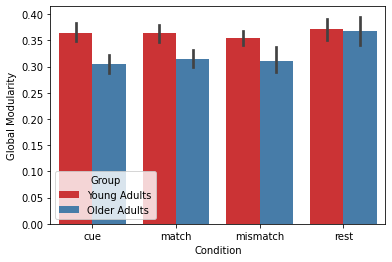

In [41]:
dfp = dfl[dfl['condition'] != 'diff']
sns.barplot(x=dfp['condition'], y=dfp['q_global'], hue=dfp['Group'])
plt.ylabel('Global Modularity'); plt.xlabel('Condition')

Text(0.5, 0, 'Condition')

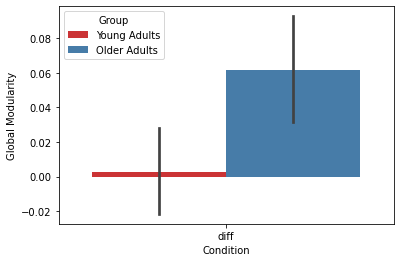

In [42]:
dfp = dfl[dfl['condition'] == 'diff']
sns.barplot(x=dfp['condition'], y=dfp['q_global'], hue=dfp['Group'])
plt.ylabel('Global Modularity'); plt.xlabel('Condition')

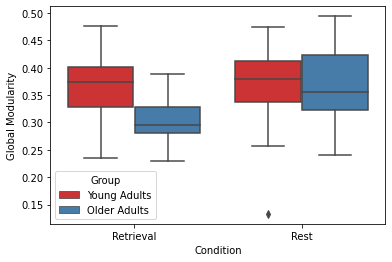

In [43]:
dfbar = dfl[(dfl['condition'].isin(['rest', 'cue']))]
ax = sns.boxplot(x=dfbar['condition'], y=dfbar['q_global'], hue=dfbar['Group'])
plt.ylabel('Global Modularity'); plt.xlabel('Condition')
ax.set_xticklabels(['Retrieval', 'Rest'])
plt.savefig('./results/globalmod_cond.png', dpi=300)

Text(0.5, 0, 'Condition')

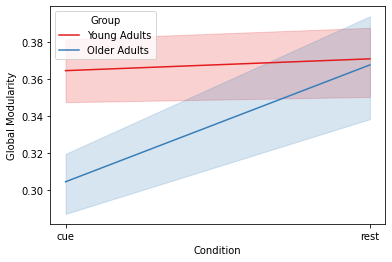

In [44]:
dfbar = dfl[(dfl['condition'].isin(['rest', 'cue']))]
sns.lineplot(x=dfbar['condition'], y=dfbar['q_global'], hue=dfbar['Group'])
plt.ylabel('Global Modularity'); plt.xlabel('Condition')

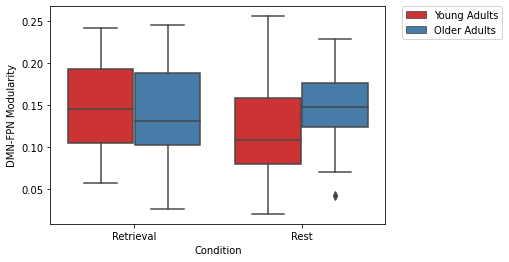

In [45]:
dfbar = dfl[(dfl['condition'].isin(['rest', 'cue']))]
ax = sns.boxplot(x=dfbar['condition'], y=dfbar['q_dmnfpn'], hue=dfbar['Group'])
plt.ylabel('DMN-FPN Modularity'); plt.xlabel('Condition')
ax.set_xticklabels(['Retrieval', 'Rest'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig('./results/dmnfpnmod_cond.png', dpi=300)

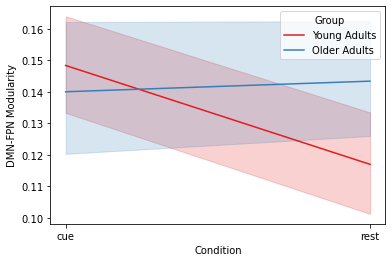

In [46]:
dfbar = dfl[(dfl['condition'].isin(['rest', 'cue']))]
sns.lineplot(x=dfbar['condition'], y=dfbar['q_dmnfpn'], hue=dfbar['Group'])
plt.ylabel('DMN-FPN Modularity'); plt.xlabel('Condition');

DMN-FPN Modularity

In [161]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_dmnfpn_cue'].dropna(), 
                df[df['Group'] == "Older Adults"]['q_dmnfpn_cue'].dropna())

Ttest_indResult(statistic=0.6313428379301895, pvalue=0.5300303942142928)

In [158]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_dmnfpn_rest'].dropna(), 
                df[df['Group'] == "Older Adults"]['q_dmnfpn_rest'].dropna())

Ttest_indResult(statistic=-1.9882402575946352, pvalue=0.05127751950797871)

In [169]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['pc_dmnfpn_cue'].dropna(), 
                df[df['Group'] == "Older Adults"]['pc_dmnfpn_cue'].dropna())

Ttest_indResult(statistic=-2.6283258357354193, pvalue=0.010629591460048505)

In [159]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_dmnfpn_rest'].dropna(), 
                df[df['Group'] == "Young Adults"]['q_dmnfpn_cue'].dropna())

Ttest_indResult(statistic=-2.7416949840297784, pvalue=0.0075572709745020525)

In [160]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Older Adults"]['q_dmnfpn_rest'].dropna(), 
                df[df['Group'] == "Older Adults"]['q_dmnfpn_cue'].dropna())

Ttest_indResult(statistic=0.22534703150703217, pvalue=0.8226863033935394)

Global modularity

In [164]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_global_rest'].dropna(), 
                df[df['Group'] == "Older Adults"]['q_global_rest'].dropna())

Ttest_indResult(statistic=0.19050641560626588, pvalue=0.849544916724119)

In [165]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_global_cue'].dropna(), 
                df[df['Group'] == "Older Adults"]['q_global_cue'].dropna())

Ttest_indResult(statistic=4.5893202500741515, pvalue=2.008524498479919e-05)

In [168]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['pc_global_cue'].dropna(), 
                df[df['Group'] == "Older Adults"]['pc_global_cue'].dropna())

Ttest_indResult(statistic=-0.06302882500745907, pvalue=0.9499312125457662)

In [166]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_global_rest'].dropna(), 
                df[df['Group'] == "Young Adults"]['q_global_cue'].dropna())

Ttest_indResult(statistic=0.48068984812540366, pvalue=0.6320327566919914)

In [167]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Older Adults"]['q_global_rest'].dropna(), 
                df[df['Group'] == "Older Adults"]['q_global_cue'].dropna())

Ttest_indResult(statistic=3.853631393810381, pvalue=0.00035194395986807203)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


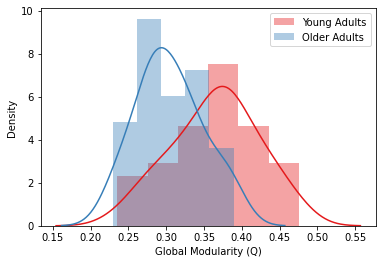

In [162]:
sns.distplot(df[df['Group'] == "Young Adults"]['q_global_cue'].dropna(), label = 'Young Adults')
sns.distplot(df[df['Group'] == "Older Adults"]['q_global_cue'].dropna(), label = 'Older Adults')
plt.xlabel('Global Modularity (Q)')
plt.legend()
plt.savefig('./results/global_modularity.png', dpi=300)

In [54]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_global_cue'].dropna(), df[df['Group'] == "Older Adults"]['q_global_cue'].dropna())

Ttest_indResult(statistic=4.5893202500741515, pvalue=2.008524498479919e-05)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


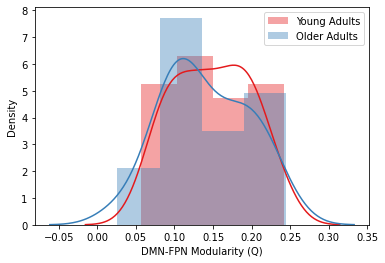

In [55]:
sns.distplot(df[df['Group'] == "Young Adults"]['q_dmnfpn_cue'].dropna(), label = 'Young Adults')
sns.distplot(df[df['Group'] == "Older Adults"]['q_dmnfpn_cue'].dropna(), label = 'Older Adults')
plt.xlabel('DMN-FPN Modularity (Q)')
plt.legend()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


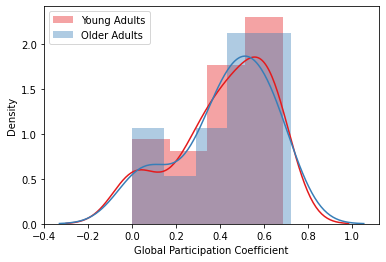

In [56]:
sns.distplot(df[df['Group'] == "Young Adults"]['pc_global_cue'].dropna(), label = 'Young Adults')
sns.distplot(df[df['Group'] == "Older Adults"]['pc_global_cue'].dropna(), label = 'Older Adults')
plt.xlabel('Global Participation Coefficient')
plt.legend()
plt.savefig('./results/global_pc.png', dpi=300)

In [57]:
dfl = df.reset_index()[['subject', 'Group'] + pcVars[2:]]
dfl = pd.wide_to_long(dfl, ['pc_global', 'pc_dmn', 'pc_fpn', 'pc_dmnfpn'], i=['subject', 'Group'], j="condition", sep='_', suffix=r'\w+')
dfl = dfl.reset_index()
dfl

,subject,Group,condition,pc_power_mismatch,pc_power_cue,pc_power_match,pc_global,pc_dmn,pc_fpn,pc_dmnfpn
0,30004,Young Adults,cue,0.281,0.421,0.572,NaN,0.439,0.293,0.132
1,30004,Young Adults,match,0.281,0.421,0.572,NaN,0.414,0.413,0.185
2,30004,Young Adults,mismatch,0.281,0.421,0.572,0.281,0.161,0.358,0.191
3,30008,Young Adults,cue,0.636,0.670,0.069,NaN,0.432,0.289,0.152
4,30008,Young Adults,match,0.636,0.670,0.069,NaN,0.333,0.447,0.182
...,...,...,...,...,...,...,...,...,...,...
271,40876,Older Adults,match,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272,40876,Older Adults,mismatch,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273,40878,Older Adults,cue,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274,40878,Older Adults,match,NaN,NaN,NaN,NaN,NaN,NaN,NaN


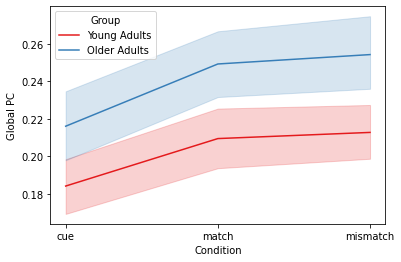

In [58]:
sns.lineplot(x=dfl['condition'], y=dfl['pc_dmnfpn'], hue=dfl['Group'])
plt.ylabel('Global PC'); plt.xlabel('Condition');

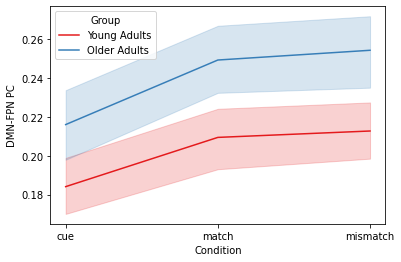

In [59]:
sns.lineplot(x=dfl['condition'], y=dfl['pc_dmnfpn'], hue=dfl['Group'])
plt.ylabel('DMN-FPN PC'); plt.xlabel('Condition');

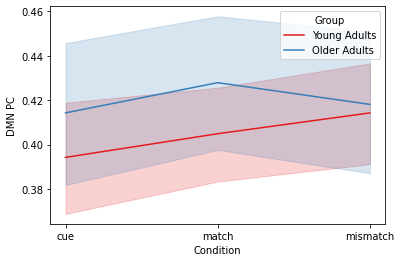

In [60]:
sns.lineplot(x=dfl['condition'], y=dfl['pc_dmn'], hue=dfl['Group'])
plt.ylabel('DMN PC'); plt.xlabel('Condition');

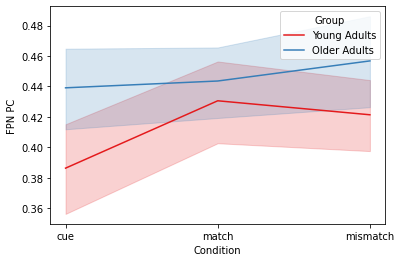

In [61]:
sns.lineplot(x=dfl['condition'], y=dfl['pc_fpn'], hue=dfl['Group'])
plt.ylabel('FPN PC'); plt.xlabel('Condition');

## Mean FC <a id='fc'></a>

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


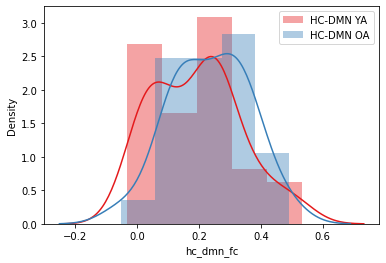

In [62]:
sns.distplot(df[df['Group'] == "Young Adults"]['hc_dmn_fc'], label = 'HC-DMN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['hc_dmn_fc'], label = 'HC-DMN OA')
plt.legend()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


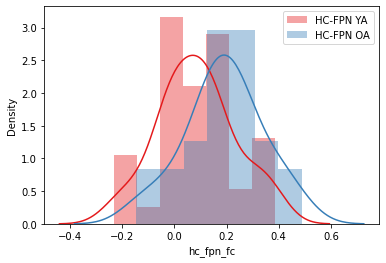

In [63]:
sns.distplot(df[df['Group'] == "Young Adults"]['hc_fpn_fc'], label = 'HC-FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['hc_fpn_fc'], label = 'HC-FPN OA')
plt.legend()

In [64]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['hc_fpn_fc'].dropna(), df[df['Group'] == "Older Adults"]['hc_fpn_fc'].dropna(), equal_var=True)

Ttest_indResult(statistic=-2.834630429993259, pvalue=0.006058605627304794)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


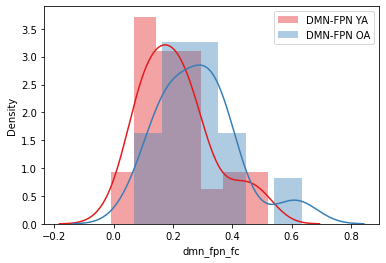

In [65]:
sns.distplot(df[df['Group'] == "Young Adults"]['dmn_fpn_fc'], label = 'DMN-FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['dmn_fpn_fc'], label = 'DMN-FPN OA')
plt.legend()

In [66]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['dmn_fpn_fc'], df[df['Group'] == "Older Adults"]['dmn_fpn_fc'], equal_var=True)

Ttest_indResult(statistic=nan, pvalue=nan)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


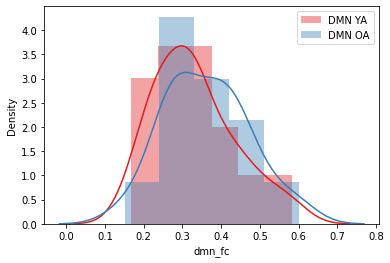

In [67]:
sns.distplot(df[df['Group'] == "Young Adults"]['dmn_fc'], label = 'DMN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['dmn_fc'], label = 'DMN OA')
plt.legend()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


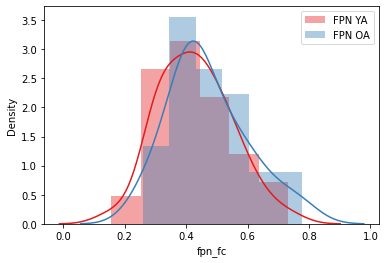

In [68]:
sns.distplot(df[df['Group'] == "Young Adults"]['fpn_fc'], label = 'FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['fpn_fc'], label = 'FPN OA')
plt.legend()

## Regression analyses <a id='reg'></a>

In [69]:
from scipy.stats.mstats import zscore

convert_dict = {'Group': str,
                'sex': str
               }
  
df = df.astype(convert_dict)

print(df.shape)

(92, 92)


In [70]:
# ya = ya.select_dtypes(include=object).join(ya.select_dtypes(include=[np.number]).apply(stats.zscore))
# abs_z_scores = ya.select_dtypes(include=[np.number]).abs()
# filtered_entries = (abs_z_scores < 3).all(axis=1)
# yaCl = ya[filtered_entries]
# yaCl.shape

In [71]:
# oa = oa.select_dtypes(include=object).join(oa.select_dtypes(include=[np.number]).apply(stats.zscore))
# abs_z_scores = oa.select_dtypes(include=[np.number]).abs()
# filtered_entries = (abs_z_scores < 3).all(axis=1)
# oaCl = oa[filtered_entries]
# oaCl.shape

In [72]:
df.groupby(['Group'])['age', 'hc_dmn_fc', 'hc_fpn_fc', 'q_global_cue'].describe()

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_50160/3237840119.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['Group'])['age', 'hc_dmn_fc', 'hc_fpn_fc', 'q_global_cue'].describe()


age                                              hc_dmn_fc  \
             count    mean    std   min   25%   50%   75%   max     count   
Group                                                                       
Older Adults  45.0  67.467  5.155  60.0  64.0  67.0  71.0  81.0      26.0   
Young Adults  47.0  21.319  3.840  18.0  18.5  19.0  24.0  30.0      43.0   

                     ... hc_fpn_fc        q_global_cue                       \
               mean  ...       75%    max        count   mean    std    min   
Group                ...                                                      
Older Adults  0.235  ...     0.264  0.490         26.0  0.305  0.043  0.229   
Young Adults  0.193  ...     0.160  0.385         43.0  0.365  0.057  0.235   

                                          
                25%    50%    75%    max  
Group                                     
Older Adults  0.280  0.296  0.329  0.389  
Young Adults  0.328  0.373  0.401  0.476  

[2 rows x 32 columns]

## Hypotheses

In [73]:
regVars = ['rt_c_test_mean', 'pc_global_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='rt_c_test_mean ~ pc_global_cue + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     14.68
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           5.32e-06
Time:                        13:19:05   Log-Likelihood:                -85.211
No. Observations:                  69   AIC:                             176.4
Df Residuals:                      66   BIC:                             183.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.6778      0.167      4.063      0.000       0.345       1.011
Group[T.Young Adults]    -1.0876      0.211     -5.146      0.000      -1.510      -0.666
pc_global_cue            -0.1777      0.102     -1.735      0.087      -0.382       0.027
==============================================================================
Omnibus:                        0.281   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.869   Jarque-Bera (JB):                0.466
Skew:                           0.010   Prob(JB):                        0.792
Kurtosis:                       2.598   Cond. No.                         3.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
regVars = ['acc_test_mean_log', 'pc_global_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='acc_test_mean_log ~ pc_global_cue * Group', data=regdf).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     2.754
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0495
Time:                        13:19:05   Log-Likelihood:                -93.779
No. Observations:                  69   AIC:                             195.6
Df Residuals:                      65   BIC:                             204.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -0.3272      0.190     -1.719      0.090      -0.707       0.053
Group[T.Young Adults]                   0.5278      0.241      2.189      0.032       0.046       1.009
pc_global_cue                          -0.2678      0.192     -1.396      0.168      -0.651       0.115
pc_global_cue:Group[T.Young Adults]     0.4477      0.242      1.851      0.069      -0.035       0.931
==============================================================================
Omnibus:                        9.898   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.662
Skew:                          -0.963   Prob(JB):                      0.00484
Kurtosis:                       3.010   Cond. No.                         3.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
regVars = ['acc_test_mean_log', 'q_dmnfpn_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='acc_test_mean_log ~ q_dmnfpn_cue + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     3.188
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0479
Time:                        13:19:05   Log-Likelihood:                -91.887
No. Observations:                  67   AIC:                             189.8
Df Residuals:                      64   BIC:                             196.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.3517      0.192     -1.835      0.071      -0.735       0.031
Group[T.Young Adults]     0.5748      0.245      2.343      0.022       0.085       1.065
q_dmnfpn_cue             -0.1343      0.120     -1.123      0.266      -0.373       0.105
==============================================================================
Omnibus:                       10.676   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.113
Skew:                          -0.985   Prob(JB):                      0.00386
Kurtosis:                       3.313   Cond. No.                         2.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [128]:
regVars = ['acc_test_mean_log', 'q_dmnfpn_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['q_dmnfpn_cue'].abs() > 3]))
regdf = regdf[regdf['q_dmnfpn_cue'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ q_dmnfpn_cue', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()


0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     3.045
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0938
Time:                        13:21:33   Log-Likelihood:                -32.008
No. Observations:                  26   AIC:                             68.02
Df Residuals:                      24   BIC:                             70.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.3660      0.170     -2.154      0.041      -0.717      -0.015
q_dmnfpn_cue    -0.2797      0.160     -1.745      0.094      -0.610       0.051
==============================================================================
Omnibus:                        0.547   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.761   Jarque-Bera (JB):                0.617
Skew:                          -0.085   Prob(JB):                        0.735
Kurtosis:                       2.265   Cond. No.                         1.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
regVars = ['rt_c_test_mean', 'q_dmnfpn_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['q_dmnfpn_cue'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ q_dmnfpn_cue + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     12.89
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           1.97e-05
Time:                        13:19:06   Log-Likelihood:                -83.729
No. Observations:                  67   AIC:                             173.5
Df Residuals:                      64   BIC:                             180.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.6746      0.170      3.975      0.000       0.336       1.014
Group[T.Young Adults]    -1.1024      0.217     -5.075      0.000      -1.536      -0.668
q_dmnfpn_cue              0.0597      0.106      0.564      0.575      -0.152       0.271
==============================================================================
Omnibus:                        0.328   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.849   Jarque-Bera (JB):                0.057
Skew:                           0.057   Prob(JB):                        0.972
Kurtosis:                       3.088   Cond. No.                         2.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
regVars = ['rt_c_test_mean', 'q_dmnfpn_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['q_dmnfpn_cue'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ q_dmnfpn_cue', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.309
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.264
Time:                        13:20:43   Log-Likelihood:                -33.759
No. Observations:                  26   AIC:                             71.52
Df Residuals:                      24   BIC:                             74.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.6880      0.182      3.786      0.001       0.313       1.063
q_dmnfpn_cue     0.1962      0.171      1.144      0.264      -0.158       0.550
==============================================================================
Omnibus:                        1.941   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.379   Jarque-Bera (JB):                0.760
Skew:                          -0.313   Prob(JB):                        0.684
Kurtosis:                       3.556   Cond. No.                         1.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
regVars = ['rt_c_test_mean', 'q_dmnfpn_diff']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['q_dmnfpn_diff'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ q_dmnfpn_diff + Group', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.094
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.308
Time:                        13:19:06   Log-Likelihood:                -30.236
No. Observations:                  23   AIC:                             64.47
Df Residuals:                      21   BIC:                             66.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7749      0.206      3.763      0.001       0.347       1.203
q_dmnfpn_diff    -0.1950      0.186     -1.046      0.308      -0.583       0.193
==============================================================================
Omnibus:                        1.232   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.540   Jarque-Bera (JB):                0.536
Skew:                          -0.371   Prob(JB):                        0.765
Kurtosis:                       3.103   Cond. No.                         1.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [179]:
regVars = ['rt_c_test_mean', 'pc_global_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf = regdf[regdf['pc_global_cue'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ pc_global_cue * Group', data=regdf).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     9.877
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           1.88e-05
Time:                        14:24:15   Log-Likelihood:                -84.948
No. Observations:                  69   AIC:                             177.9
Df Residuals:                      65   BIC:                             186.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.6787      0.167      4.053      0.000       0.344       1.013
Group[T.Young Adults]                  -1.0882      0.212     -5.130      0.000      -1.512      -0.665
pc_global_cue                          -0.2720      0.169     -1.611      0.112      -0.609       0.065
pc_global_cue:Group[T.Young Adults]     0.1499      0.213      0.705      0.484      -0.275       0.575
==============================================================================
Omnibus:                        0.601   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.741   Jarque-Bera (JB):                0.697
Skew:                           0.053   Prob(JB):                        0.706
Kurtosis:                       2.519   Cond. No.                         3.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [178]:
regVars = ['rt_c_test_mean', 'pc_global_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf = regdf[regdf['pc_global_cue'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ pc_global_cue', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     2.293
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.143
Time:                        14:24:06   Log-Likelihood:                -33.358
No. Observations:                  26   AIC:                             70.72
Df Residuals:                      24   BIC:                             73.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6787      0.178      3.809      0.001       0.311       1.046
pc_global_cue    -0.2720      0.180     -1.514      0.143      -0.643       0.099
==============================================================================
Omnibus:                        0.039   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.981   Jarque-Bera (JB):                0.243
Skew:                           0.042   Prob(JB):                        0.885
Kurtosis:                       2.534   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
regVars = ['acc_test_mean_log', 'pc_dmnfpn_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['pc_dmnfpn_cue'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ pc_dmnfpn_cue + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     4.429
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0157
Time:                        13:19:06   Log-Likelihood:                -93.562
No. Observations:                  69   AIC:                             193.1
Df Residuals:                      66   BIC:                             199.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.4245      0.194     -2.186      0.032      -0.812      -0.037
Group[T.Young Adults]     0.6812      0.251      2.719      0.008       0.181       1.181
pc_dmnfpn_cue             0.2407      0.121      1.983      0.052      -0.002       0.483
==============================================================================
Omnibus:                        7.378   Durbin-Watson:                   1.689
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.480
Skew:                          -0.806   Prob(JB):                       0.0237
Kurtosis:                       2.963   Cond. No.                         3.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
smf.ols(formula='acc_test_mean_log ~ pc_dmnfpn_cue', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     4.383
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0470
Time:                        13:19:06   Log-Likelihood:                -31.263
No. Observations:                  26   AIC:                             66.53
Df Residuals:                      24   BIC:                             69.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.4719      0.178     -2.654      0.014      -0.839      -0.105
pc_dmnfpn_cue     0.3612      0.173      2.094      0.047       0.005       0.717
==============================================================================
Omnibus:                        0.134   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.935   Jarque-Bera (JB):                0.043
Skew:                          -0.062   Prob(JB):                        0.979
Kurtosis:                       2.845   Cond. No.                         1.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [181]:
regVars = ['rt_c_test_mean', 'dmn_fpn_fc']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf = regdf[regdf['dmn_fpn_fc'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ dmn_fpn_fc + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     15.70
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           2.74e-06
Time:                        14:25:52   Log-Likelihood:                -83.587
No. Observations:                  68   AIC:                             173.2
Df Residuals:                      65   BIC:                             179.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.6503      0.171      3.796      0.000       0.308       0.992
Group[T.Young Adults]    -1.0118      0.219     -4.628      0.000      -1.448      -0.575
dmn_fpn_fc                0.2264      0.113      2.011      0.048       0.002       0.451
==============================================================================
Omnibus:                        0.158   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.924   Jarque-Bera (JB):                0.139
Skew:                           0.098   Prob(JB):                        0.933
Kurtosis:                       2.896   Cond. No.                         3.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [184]:
regVars = ['acc_test_mean_log', 'dmn_fpn_fc']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf = regdf[regdf['dmn_fpn_fc'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ dmn_fpn_fc + Group', data=regdf).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     4.493
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0149
Time:                        14:26:51   Log-Likelihood:                -91.952
No. Observations:                  68   AIC:                             189.9
Df Residuals:                      65   BIC:                             196.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.3352      0.194     -1.730      0.088      -0.722       0.052
Group[T.Young Adults]     0.4884      0.247      1.975      0.052      -0.005       0.982
dmn_fpn_fc               -0.2217      0.127     -1.741      0.086      -0.476       0.033
==============================================================================
Omnibus:                       11.547   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.188
Skew:                          -1.019   Prob(JB):                      0.00226
Kurtosis:                       3.389   Cond. No.                         3.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
regVars = ['acc_test_mean_log', 'hc_fpn_fc']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['hc_fpn_fc'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ hc_fpn_fc * Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     3.476
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0209
Time:                        13:19:06   Log-Likelihood:                -92.774
No. Observations:                  69   AIC:                             193.5
Df Residuals:                      65   BIC:                             202.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.4885      0.205     -2.382      0.020      -0.898      -0.079
Group[T.Young Adults]               0.6350      0.255      2.493      0.015       0.126       1.144
hc_fpn_fc                           0.3768      0.197      1.914      0.060      -0.016       0.770
hc_fpn_fc:Group[T.Young Adults]    -0.5850      0.251     -2.334      0.023      -1.086      -0.084
==============================================================================
Omnibus:                       11.642   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.413
Skew:                          -1.025   Prob(JB):                      0.00202
Kurtosis:                       3.342   Cond. No.                         3.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [187]:
regVars = ['acc_test_mean_log', 'hc_fpn_fc']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['hc_fpn_fc'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ hc_fpn_fc', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     4.848
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0375
Time:                        14:33:00   Log-Likelihood:                -31.052
No. Observations:                  26   AIC:                             66.10
Df Residuals:                      24   BIC:                             68.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4885      0.178     -2.740      0.011      -0.856      -0.121
hc_fpn_fc      0.3768      0.171      2.202      0.038       0.024       0.730
==============================================================================
Omnibus:                        0.677   Durbin-Watson:                   2.443
Prob(Omnibus):                  0.713   Jarque-Bera (JB):                0.749
Skew:                          -0.268   Prob(JB):                        0.688
Kurtosis:                       2.364   Cond. No.                         1.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
regVars = ['rt_c_test_mean', 'hc_fpn_fc']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['hc_fpn_fc'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ hc_fpn_fc + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     13.29
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           1.41e-05
Time:                        13:19:06   Log-Likelihood:                -86.233
No. Observations:                  69   AIC:                             178.5
Df Residuals:                      66   BIC:                             185.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.6298      0.176      3.588      0.001       0.279       0.980
Group[T.Young Adults]    -1.0107      0.227     -4.453      0.000      -1.464      -0.558
hc_fpn_fc                 0.1097      0.110      0.998      0.322      -0.110       0.329
==============================================================================
Omnibus:                        0.356   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.837   Jarque-Bera (JB):                0.112
Skew:                           0.094   Prob(JB):                        0.945
Kurtosis:                       3.062   Cond. No.                         3.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
regVars = ['acc_test_mean_log', 'hc_dmn_fc']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['hc_dmn_fc'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ hc_dmn_fc + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     3.073
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0530
Time:                        13:19:06   Log-Likelihood:                -94.835
No. Observations:                  69   AIC:                             195.7
Df Residuals:                      66   BIC:                             202.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.3030      0.193     -1.569      0.121      -0.689       0.083
Group[T.Young Adults]     0.4862      0.246      1.979      0.052      -0.004       0.977
hc_dmn_fc                -0.1408      0.119     -1.182      0.241      -0.378       0.097
==============================================================================
Omnibus:                        8.977   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.362
Skew:                          -0.902   Prob(JB):                      0.00927
Kurtosis:                       3.044   Cond. No.                         3.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
regVars = ['rt_c_test_mean', 'hc_dmn_fc']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['hc_dmn_fc'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ hc_dmn_fc + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     12.94
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           1.82e-05
Time:                        13:19:06   Log-Likelihood:                -86.494
No. Observations:                  69   AIC:                             179.0
Df Residuals:                      66   BIC:                             185.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.6619      0.171      3.868      0.000       0.320       1.004
Group[T.Young Adults]    -1.0622      0.218     -4.879      0.000      -1.497      -0.628
hc_dmn_fc                 0.0738      0.105      0.699      0.487      -0.137       0.284
==============================================================================
Omnibus:                        0.420   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.811   Jarque-Bera (JB):                0.119
Skew:                           0.087   Prob(JB):                        0.942
Kurtosis:                       3.105   Cond. No.                         3.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [195]:
regVars = ['acc_test_mean_log', 'hc_fpn_fc', 'fpn_fc']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['hc_fpn_fc'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ Group * fpn_fc', data=regdf).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     2.938
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0397
Time:                        14:37:07   Log-Likelihood:                -93.520
No. Observations:                  69   AIC:                             195.0
Df Residuals:                      65   BIC:                             204.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.3408      0.194     -1.759      0.083      -0.728       0.046
Group[T.Young Adults]            0.5007      0.244      2.049      0.044       0.013       0.989
fpn_fc                           0.0504      0.185      0.273      0.785      -0.318       0.419
Group[T.Young Adults]:fpn_fc    -0.3531      0.240     -1.471      0.146      -0.833       0.126
==============================================================================
Omnibus:                       10.295   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.639
Skew:                          -0.951   Prob(JB):                      0.00489
Kurtosis:                       3.288   Cond. No.                         3.34
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Brain - Memory Associations

### Modularity

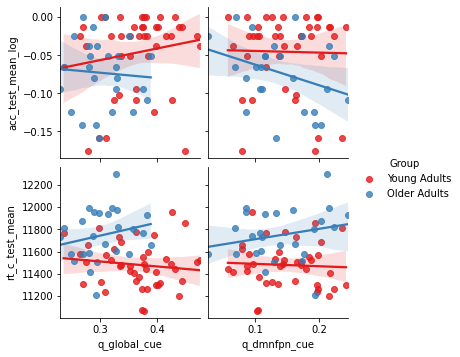

In [86]:
sns.set_palette('Set1')
modVars_ = [v for v in modVars if not 'power' in v and 'cue' in v]
sns.pairplot(data=df, y_vars=['acc_test_mean_log', 'rt_c_test_mean'], x_vars=modVars_, hue='Group', kind='reg')

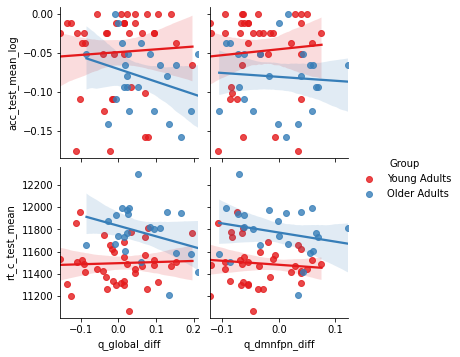

In [87]:
sns.set_palette('Set1')
modVars_ = [v for v in modVars if 'diff' in v]
sns.pairplot(data=df, x_vars=modVars_, y_vars=['acc_test_mean_log', 'rt_c_test_mean'], hue='Group', kind='reg')

### Participation coefficient

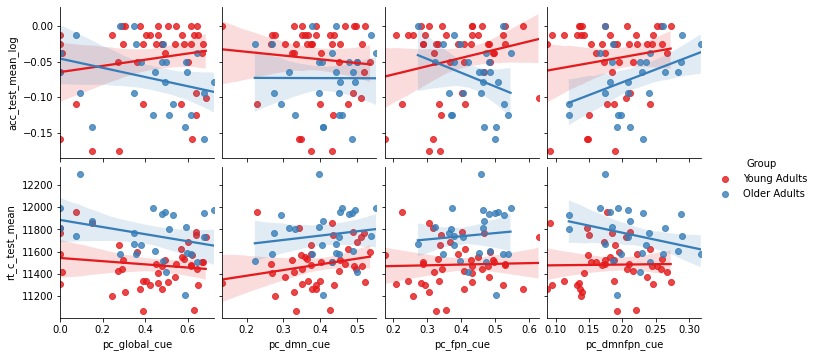

In [88]:
sns.set_palette('Set1')
pcVars_ = [v for v in pcVars if 'cue' in v and not 'power' in v]
sns.pairplot(data=df, y_vars=['acc_test_mean_log', 'rt_c_test_mean'], x_vars=pcVars_, hue='Group', kind='reg')

### Mean FC

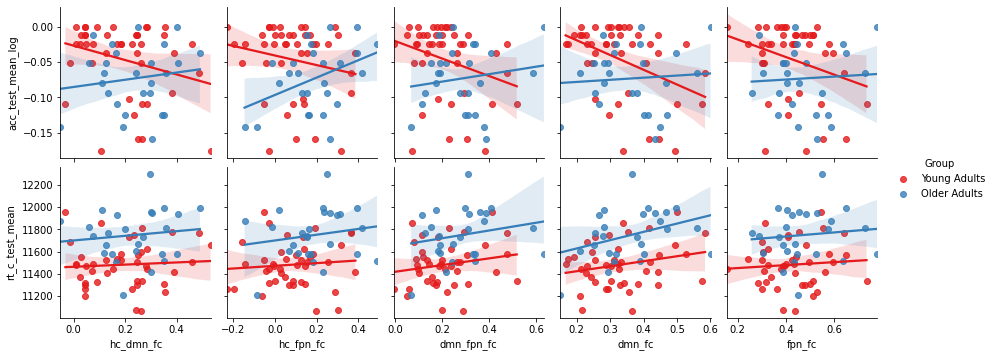

In [89]:
sns.set_palette('Set1')
sns.pairplot(data=df, y_vars=['acc_test_mean_log', 'rt_c_test_mean'], x_vars=fcVars, hue='Group', kind='reg')

### NBS Edge Strength

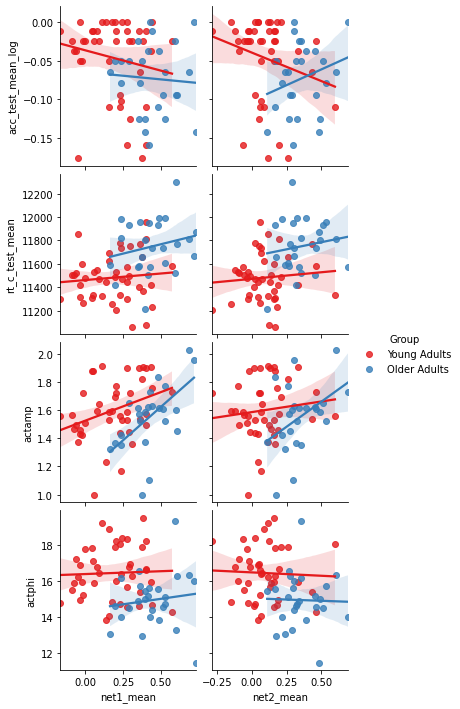

In [90]:
sns.set_palette('Set1')
sns.pairplot(data=df, y_vars=['acc_test_mean_log', 'rt_c_test_mean', 'actamp', 'actphi'], 
             x_vars=['net1_mean', 'net2_mean'], hue='Group', kind='reg')

## Exploratory 

In [197]:
regVars = ['rt_c_test_mean', 'net1_mean']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['net1_mean'].abs() > 3]))
regdf = regdf[regdf['net1_mean'].abs() < 3]
smf.ols(formula='rt_c_test_mean ~ net1_mean + Group', data=regdf).fit().summary()


0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     13.51
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           1.21e-05
Time:                        14:47:05   Log-Likelihood:                -86.066
No. Observations:                  69   AIC:                             178.1
Df Residuals:                      66   BIC:                             184.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.5597      0.197      2.842      0.006       0.167       0.953
Group[T.Young Adults]    -0.8981      0.269     -3.343      0.001      -1.434      -0.362
net1_mean                 0.1496      0.130      1.149      0.255      -0.110       0.409
==============================================================================
Omnibus:                        0.136   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.934   Jarque-Bera (JB):                0.001
Skew:                           0.007   Prob(JB):                         1.00
Kurtosis:                       2.998   Cond. No.                         3.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
regVars = ['acc_test_mean', 'net2_mean']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['net2_mean'].abs() > 3]))
regdf = regdf[regdf['net2_mean'].abs() < 3]
smf.ols(formula='acc_test_mean ~ net2_mean * Group', data=regdf).fit().summary()


0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          acc_test_mean   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     3.222
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0283
Time:                        13:19:28   Log-Likelihood:                -93.124
No. Observations:                  69   AIC:                             194.2
Df Residuals:                      65   BIC:                             203.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.6181      0.295     -2.098      0.040      -1.206      -0.030
Group[T.Young Adults]               0.6825      0.341      2.001      0.050       0.001       1.364
net2_mean                           0.3239      0.275      1.179      0.243      -0.225       0.872
net2_mean:Group[T.Young Adults]    -0.6206      0.329     -1.889      0.063      -1.277       0.036
==============================================================================
Omnibus:                        8.074   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.293
Skew:                          -0.849   Prob(JB):                       0.0158
Kurtosis:                       2.994   Cond. No.                         6.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
regVars = ['rt_c_test_mean', 'net2_mean']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['net2_mean'].abs() > 3]))
regdf = regdf[regdf['net2_mean'].abs() < 3]
smf.ols(formula='rt_c_test_mean ~ net2_mean + Group', data=regdf).fit().summary()


0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     13.17
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           1.54e-05
Time:                        13:19:28   Log-Likelihood:                -86.323
No. Observations:                  69   AIC:                             178.6
Df Residuals:                      66   BIC:                             185.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.5749      0.203      2.831      0.006       0.169       0.980
Group[T.Young Adults]    -0.9225      0.280     -3.297      0.002      -1.481      -0.364
net2_mean                 0.1227      0.136      0.905      0.369      -0.148       0.393
==============================================================================
Omnibus:                        0.436   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.804   Jarque-Bera (JB):                0.244
Skew:                           0.146   Prob(JB):                        0.885
Kurtosis:                       3.008   Cond. No.                         4.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
regVars = ['net1_mean', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

print(len(regdf[regdf['actamp'].abs() > 3]))
print(len(regdf[regdf['net1_mean'].abs() > 3]))

smf.ols(formula='net1_mean ~ actamp + Group', data=regdf).fit().summary()

0
0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              net1_mean   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     26.11
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           5.13e-09
Time:                        13:19:28   Log-Likelihood:                -75.085
No. Observations:                  67   AIC:                             156.2
Df Residuals:                      64   BIC:                             162.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.8220      0.156      5.285      0.000       0.511       1.133
Group[T.Young Adults]    -1.2807      0.195     -6.584      0.000      -1.669      -0.892
actamp                    0.3398      0.093      3.643      0.001       0.153       0.526
==============================================================================
Omnibus:                        3.106   Durbin-Watson:                   1.200
Prob(Omnibus):                  0.212   Jarque-Bera (JB):                1.754
Skew:                          -0.084   Prob(JB):                        0.416
Kurtosis:                       2.225   Cond. No.                         3.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [170]:
regVars = ['net2_mean', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['actamp'].abs() > 3]))
print(len(regdf[regdf['net2_mean'].abs() > 3]))
regdf = regdf[regdf['actamp'].abs() < 3]
regdf = regdf[regdf['net2_mean'].abs() < 3]

smf.ols(formula='net2_mean ~ actamp', 
        data=regdf).fit().summary()

0
0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              net2_mean   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.7858
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.379
Time:                        14:09:20   Log-Likelihood:                -94.666
No. Observations:                  67   AIC:                             193.3
Df Residuals:                      65   BIC:                             197.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.429e-16      0.123   1.97e-15      1.000      -0.246       0.246
actamp         0.1093      0.123      0.886      0.379      -0.137       0.356
==============================================================================
Omnibus:                        0.905   Durbin-Watson:                   1.491
Prob(Omnibus):                  0.636   Jarque-Bera (JB):                0.888
Skew:                           0.264   Prob(JB):                        0.642
Kurtosis:                       2.803   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [95]:
regVars = ['net2_mean', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['actamp'].abs() > 3]))
print(len(regdf[regdf['net2_mean'].abs() > 3]))
regdf = regdf[regdf['actamp'].abs() < 3]
regdf = regdf[regdf['net2_mean'].abs() < 3]

smf.ols(formula='net2_mean ~ actamp', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()

0
0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              net2_mean   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     4.990
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0360
Time:                        13:19:28   Log-Likelihood:                -23.264
No. Observations:                  24   AIC:                             50.53
Df Residuals:                      22   BIC:                             52.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8771      0.137      6.395      0.000       0.593       1.162
actamp         0.2865      0.128      2.234      0.036       0.021       0.553
==============================================================================
Omnibus:                        0.303   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.859   Jarque-Bera (JB):                0.207
Skew:                           0.200   Prob(JB):                        0.902
Kurtosis:                       2.785   Cond. No.                         1.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
df[['acc_test_mean', 'rt_c_test_mean'] + fcVars].corr()

,acc_test_mean,rt_c_test_mean,hc_dmn_fc,hc_fpn_fc,dmn_fpn_fc,dmn_fc,fpn_fc
acc_test_mean,1.000,-0.565,-0.177,-0.076,-0.197,-0.274,-0.196
rt_c_test_mean,-0.565,1.000,0.150,0.270,0.298,0.312,0.163
hc_dmn_fc,-0.177,0.150,1.000,0.724,0.530,0.502,0.467
hc_fpn_fc,-0.076,0.270,0.724,1.000,0.618,0.489,0.471
dmn_fpn_fc,-0.197,0.298,0.530,0.618,1.000,0.886,0.771
dmn_fc,-0.274,0.312,0.502,0.489,0.886,1.000,0.726
fpn_fc,-0.196,0.163,0.467,0.471,0.771,0.726,1.000


## RAR - Brain Associations

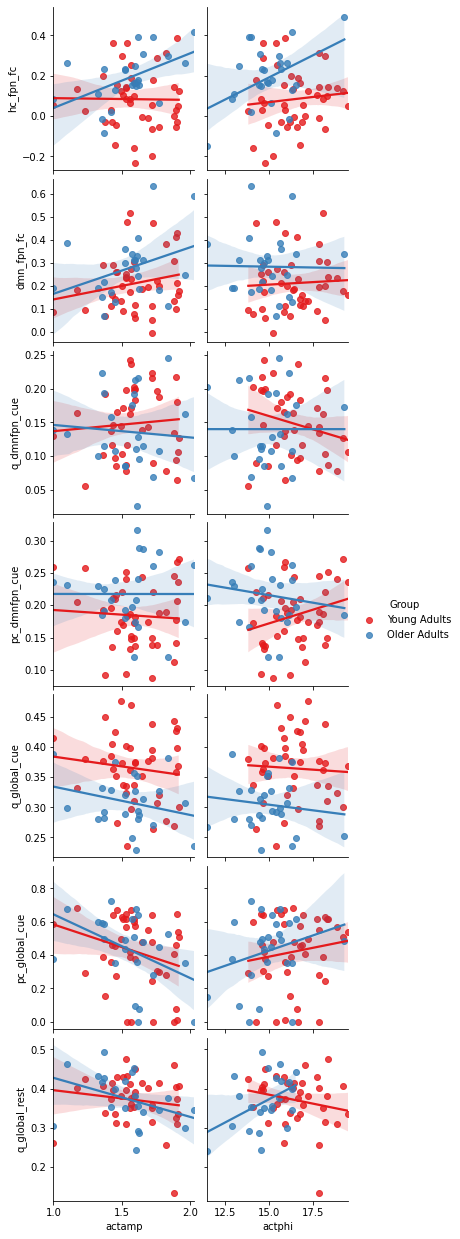

In [185]:
sns.set_palette('Set1')
sns.pairplot(data=df, x_vars=['actamp', 'actphi'],
             y_vars=['hc_fpn_fc', 'dmn_fpn_fc', 'q_dmnfpn_cue', 'pc_dmnfpn_cue', 'q_global_cue', 'pc_global_cue', 'q_global_rest'], hue='Group', kind='reg')

In [98]:
regVars = ['q_global_rest', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['actamp'].abs() > 3]))
print(len(regdf[regdf['q_global_rest'].abs() > 3]))

regdf = regdf[regdf['q_global_rest'].abs() < 3]

smf.ols(formula='q_global_rest ~ actamp + Group', 
        data=regdf).fit().summary()




0
1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          q_global_rest   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9577
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.390
Time:                        13:19:35   Log-Likelihood:                -77.879
No. Observations:                  61   AIC:                             161.8
Df Residuals:                      58   BIC:                             168.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0015      0.190      0.008      0.994      -0.380       0.383
Group[T.Young Adults]     0.0894      0.238      0.375      0.709      -0.388       0.567
actamp                   -0.1571      0.115     -1.363      0.178      -0.388       0.074
==============================================================================
Omnibus:                        1.738   Durbin-Watson:                   1.712
Prob(Omnibus):                  0.419   Jarque-Bera (JB):                1.538
Skew:                          -0.384   Prob(JB):                        0.463
Kurtosis:                       2.872   Cond. No.                         3.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [99]:
regVars = ['q_global_rest', 'actphi']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['actphi'].abs() > 3]))
print(len(regdf[regdf['q_global_rest'].abs() > 3]))

regdf = regdf[regdf['q_global_rest'].abs() < 3]

smf.ols(formula='q_global_rest ~ actphi * Group', 
        data=regdf).fit().summary()



0
1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          q_global_rest   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     2.451
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0725
Time:                        13:19:35   Log-Likelihood:                -77.217
No. Observations:                  62   AIC:                             162.4
Df Residuals:                      58   BIC:                             170.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.3631      0.240      1.511      0.136      -0.118       0.844
Group[T.Young Adults]           -0.2031      0.284     -0.716      0.477      -0.771       0.364
actphi                           0.5815      0.232      2.504      0.015       0.117       1.046
actphi:Group[T.Young Adults]    -0.7092      0.279     -2.541      0.014      -1.268      -0.151
==============================================================================
Omnibus:                        0.034   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.983   Jarque-Bera (JB):                0.087
Skew:                          -0.047   Prob(JB):                        0.957
Kurtosis:                       2.842   Cond. No.                         5.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
regVars = ['pc_global_cue', 'actphi']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='pc_global_cue ~ actphi + Group', 
        data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pc_global_cue   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.214
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.303
Time:                        13:19:36   Log-Likelihood:                -96.660
No. Observations:                  69   AIC:                             199.3
Df Residuals:                      66   BIC:                             206.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.1299      0.211      0.614      0.541      -0.292       0.552
Group[T.Young Adults]    -0.2084      0.278     -0.748      0.457      -0.764       0.347
actphi                    0.2101      0.135      1.557      0.124      -0.059       0.479
==============================================================================
Omnibus:                        5.448   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                5.477
Skew:                          -0.660   Prob(JB):                       0.0647
Kurtosis:                       2.596   Cond. No.                         3.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [101]:
regVars = ['pc_global_cue', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='pc_global_cue ~ actamp + Group', 
        data=regdf).fit().summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pc_global_cue   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     3.899
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0252
Time:                        13:19:36   Log-Likelihood:                -91.217
No. Observations:                  67   AIC:                             188.4
Df Residuals:                      64   BIC:                             195.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.0081      0.198     -0.041      0.967      -0.403       0.387
Group[T.Young Adults]     0.0126      0.247      0.051      0.959      -0.482       0.507
actamp                   -0.3301      0.119     -2.782      0.007      -0.567      -0.093
==============================================================================
Omnibus:                        6.203   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                5.782
Skew:                          -0.652   Prob(JB):                       0.0555
Kurtosis:                       2.390   Cond. No.                         3.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [102]:
regVars = ['q_global_cue', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='q_global_cue ~ actamp + Group', 
        data=regdf).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           q_global_cue   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     9.704
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           0.000208
Time:                        13:19:36   Log-Likelihood:                -86.196
No. Observations:                  67   AIC:                             178.4
Df Residuals:                      64   BIC:                             185.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.6367      0.184     -3.468      0.001      -1.003      -0.270
Group[T.Young Adults]     0.9921      0.230      4.321      0.000       0.533       1.451
actamp                   -0.1434      0.110     -1.303      0.197      -0.363       0.076
==============================================================================
Omnibus:                        0.170   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.918   Jarque-Bera (JB):                0.360
Skew:                          -0.060   Prob(JB):                        0.835
Kurtosis:                       2.662   Cond. No.                         3.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [103]:
regVars = ['pc_dmnfpn_cue', 'actphi']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='pc_dmnfpn_cue ~ actphi * Group', 
        data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pc_dmnfpn_cue   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     3.465
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0211
Time:                        13:19:36   Log-Likelihood:                -92.789
No. Observations:                  69   AIC:                             193.6
Df Residuals:                      65   BIC:                             202.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.3071      0.223      1.380      0.172      -0.137       0.752
Group[T.Young Adults]           -0.6394      0.272     -2.351      0.022      -1.183      -0.096
actphi                          -0.1507      0.210     -0.719      0.475      -0.569       0.268
actphi:Group[T.Young Adults]     0.4244      0.265      1.600      0.115      -0.105       0.954
==============================================================================
Omnibus:                        0.855   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.652   Jarque-Bera (JB):                0.846
Skew:                           0.051   Prob(JB):                        0.655
Kurtosis:                       2.467   Cond. No.                         4.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [104]:
regVars = ['hc_fpn_fc', 'actphi']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='hc_fpn_fc ~ actphi + Group', 
        data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hc_fpn_fc   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     5.997
Date:                Sun, 06 Mar 2022   Prob (F-statistic):            0.00405
Time:                        13:19:36   Log-Likelihood:                -92.146
No. Observations:                  69   AIC:                             190.3
Df Residuals:                      66   BIC:                             197.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.5585      0.198      2.820      0.006       0.163       0.954
Group[T.Young Adults]    -0.8962      0.261     -3.437      0.001      -1.417      -0.376
actphi                    0.2412      0.126      1.908      0.061      -0.011       0.493
==============================================================================
Omnibus:                        0.576   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.750   Jarque-Bera (JB):                0.687
Skew:                           0.195   Prob(JB):                        0.709
Kurtosis:                       2.706   Cond. No.                         3.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
regVars = ['hc_fpn_fc', 'actphi']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='hc_fpn_fc ~ actphi + Group', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hc_fpn_fc   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     5.575
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0267
Time:                        13:19:36   Log-Likelihood:                -32.917
No. Observations:                  26   AIC:                             69.83
Df Residuals:                      24   BIC:                             72.35
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6847      0.208      3.295      0.003       0.256       1.114
actphi         0.4621      0.196      2.361      0.027       0.058       0.866
==============================================================================
Omnibus:                        0.377   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.828   Jarque-Bera (JB):                0.242
Skew:                          -0.218   Prob(JB):                        0.886
Kurtosis:                       2.820   Cond. No.                         1.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
regVars = ['hc_fpn_fc', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='hc_fpn_fc ~ actamp * Group', 
        data=regdf).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hc_fpn_fc   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     4.753
Date:                Sun, 06 Mar 2022   Prob (F-statistic):            0.00474
Time:                        13:19:36   Log-Likelihood:                -88.234
No. Observations:                  67   AIC:                             184.5
Df Residuals:                      63   BIC:                             193.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.5184      0.192      2.704      0.009       0.135       0.902
Group[T.Young Adults]           -0.7757      0.239     -3.247      0.002      -1.253      -0.298
actamp                           0.4018      0.179      2.241      0.029       0.043       0.760
actamp:Group[T.Young Adults]    -0.4147      0.233     -1.781      0.080      -0.880       0.051
==============================================================================
Omnibus:                        0.111   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.946   Jarque-Bera (JB):                0.087
Skew:                           0.074   Prob(JB):                        0.958
Kurtosis:                       2.905   Cond. No.                         3.25
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
regVars = ['hc_fpn_fc', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='hc_fpn_fc ~ actamp + Group', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hc_fpn_fc   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     7.681
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0111
Time:                        13:19:36   Log-Likelihood:                -26.200
No. Observations:                  24   AIC:                             56.40
Df Residuals:                      22   BIC:                             58.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5184      0.155      3.345      0.003       0.197       0.840
actamp         0.4018      0.145      2.771      0.011       0.101       0.702
==============================================================================
Omnibus:                        0.127   Durbin-Watson:                   2.289
Prob(Omnibus):                  0.939   Jarque-Bera (JB):                0.231
Skew:                          -0.148   Prob(JB):                        0.891
Kurtosis:                       2.621   Cond. No.                         1.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

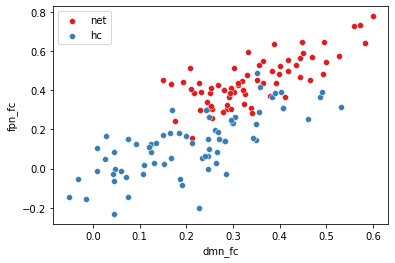

In [108]:
sns.scatterplot(data=df, x='dmn_fc', y='fpn_fc', label='net')
sns.scatterplot(data=df, x='hc_dmn_fc', y='hc_fpn_fc', label='hc')
plt.legend()

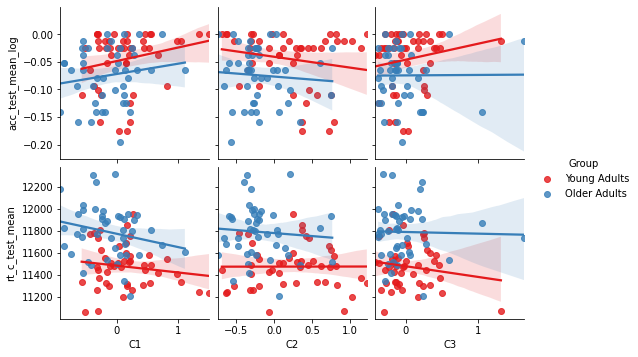

In [109]:
sns.pairplot(data=df, y_vars=['acc_test_mean_log', 'rt_c_test_mean'],
            x_vars=pcaVars, hue='Group', kind='reg')

### Mediation

In [220]:
regVars = ['actamp', 'pc_global_cue', 'acc_test_mean_log']
regdf = df[['GroupBin', 'sex'] + regVars].dropna()[['GroupBin', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

print(len(regdf[regdf['pc_global_cue'].abs() > 3]))
regdf = regdf[regdf['pc_global_cue'].abs() < 3]

medtab = pg.mediation_analysis(data=regdf[regdf['GroupBin'] == 1], 
                               x='actamp', 
                               m='pc_global_cue', 
                               y='acc_test_mean_log',
                               alpha=0.05)
medtab.to_latex('./results/mediation_tab1.tex')
medtab

0


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,pc_global_cue ~ X,-0.399,0.181,0.038,-0.773,-0.024,Yes
1,Y ~ pc_global_cue,-0.380,0.165,0.031,-0.722,-0.039,Yes
2,Total,0.273,0.162,0.105,-0.062,0.608,No
3,Direct,0.148,0.171,0.396,-0.208,0.505,No
4,Indirect,0.125,0.078,0.056,0.020,0.375,No


In [221]:
regVars = ['actamp', 'hc_fpn_fc', 'acc_test_mean_log']
regdf = df[['GroupBin', 'sex'] + regVars].dropna()[['GroupBin', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

print(len(regdf[regdf['hc_fpn_fc'].abs() > 3]))
regdf = regdf[regdf['hc_fpn_fc'].abs() < 3]

medtab = pg.mediation_analysis(data=regdf[regdf['GroupBin'] == 1], 
                               x='actamp', 
                               m='hc_fpn_fc', 
                               y='acc_test_mean_log',
                               alpha=0.05)
medtab.to_latex('./results/mediation_tab2.tex')
medtab

0


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,hc_fpn_fc ~ X,0.402,0.145,0.011,0.101,0.702,Yes
1,Y ~ hc_fpn_fc,0.260,0.210,0.229,-0.176,0.697,No
2,Total,0.273,0.162,0.105,-0.062,0.608,No
3,Direct,0.227,0.191,0.248,-0.170,0.625,No
4,Indirect,0.046,0.135,0.608,-0.136,0.371,No


In [222]:
smf.ols('acc_test_mean_log ~ hc_fpn_fc', 
        data=df[df['Group'] == 'Older Adults']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     4.848
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0375
Time:                        15:02:16   Log-Likelihood:                 46.545
No. Observations:                  26   AIC:                            -89.09
Df Residuals:                      24   BIC:                            -86.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0963      0.013     -7.205      0.000      -0.124      -0.069
hc_fpn_fc      0.1227      0.056      2.202      0.038       0.008       0.238
==============================================================================
Omnibus:                        0.677   Durbin-Watson:                   2.443
Prob(Omnibus):                  0.713   Jarque-Bera (JB):                0.749
Skew:                          -0.268   Prob(JB):                        0.688
Kurtosis:                       2.364   Cond. No.                         7.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Plots

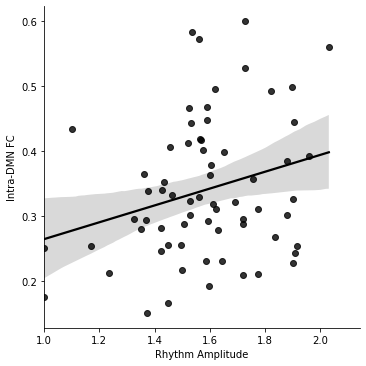

In [111]:
sns.lmplot(data=df, x='actamp', y='dmn_fc',
             scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Intra-DMN FC')
plt.savefig('./results/amp_dmnfc.png', dpi=300)

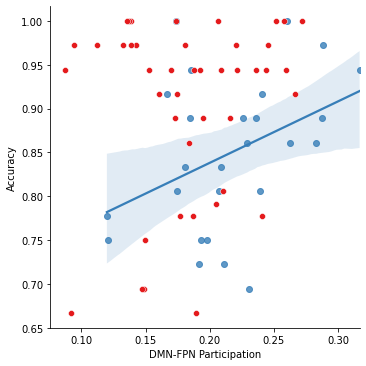

In [228]:
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='pc_dmnfpn_cue', y='acc_test_mean', scatter_kws={'color': sns.color_palette('Set1')[1]}, line_kws={'color': sns.color_palette('Set1')[1]})
sns.scatterplot(data=df[df['Group'] == 'Young Adults'], x='pc_dmnfpn_cue', y='acc_test_mean', color =sns.color_palette('Set1')[0])
plt.ylabel('Accuracy'); plt.xlabel('DMN-FPN Participation')
plt.savefig('./results/pcDF_acc.png', dpi=300)

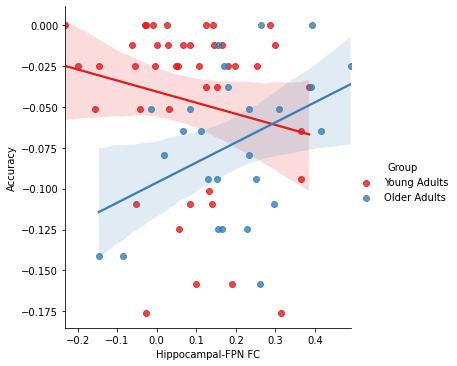

In [112]:
sns.lmplot(data=df, x='hc_fpn_fc', y='acc_test_mean_log', hue='Group')
plt.ylabel('Accuracy'); plt.xlabel('Hippocampal-FPN FC')
plt.savefig('./results/hcfpnfc_acc.png', dpi=300)

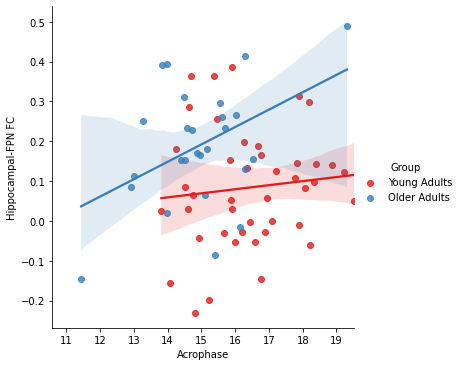

In [245]:
sns.lmplot(data=df, x='actphi', y='hc_fpn_fc', hue='Group')
plt.xlabel('Acrophase'); plt.ylabel('Hippocampal-FPN FC')
plt.savefig('./results/phi_hcfpnfc.png', dpi=300)

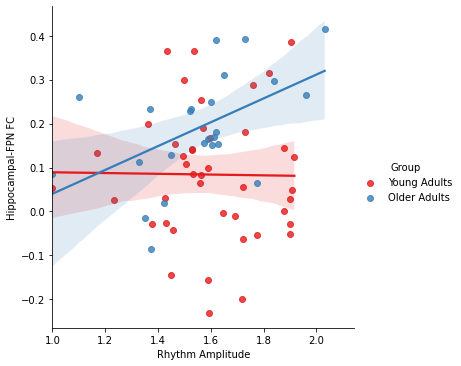

In [113]:
sns.lmplot(data=df, x='actamp', y='hc_fpn_fc', hue='Group')
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Hippocampal-FPN FC')
plt.savefig('./results/amp_hcfpnfc.png', dpi=300)

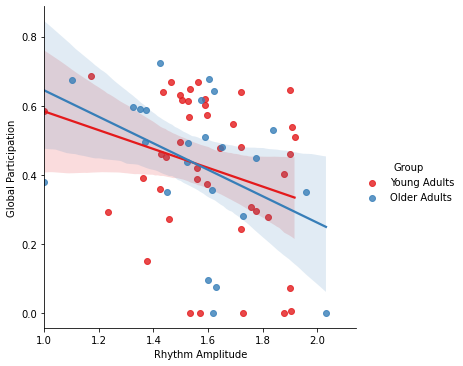

In [246]:
sns.lmplot(data=df, x='actamp', y='pc_global_cue', hue='Group')
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Global Participation')
plt.savefig('./results/amp_pcglobalcue.png', dpi=300)

In [114]:
sns.color_palette('Set1')[1]

(0.21568627450980393, 0.49411764705882355, 0.7215686274509804)

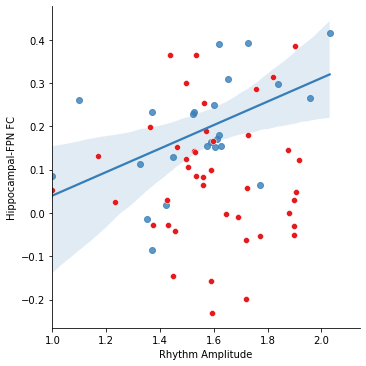

In [229]:
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='actamp', y='hc_fpn_fc', scatter_kws={'color': sns.color_palette('Set1')[1]}, line_kws={'color': sns.color_palette('Set1')[1]})
sns.scatterplot(data=df[df['Group'] == 'Young Adults'], x='actamp', y='hc_fpn_fc', color =sns.color_palette('Set1')[0])
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Hippocampal-FPN FC')
plt.savefig('./results/amp_hcfpnfc_oa.png', dpi=300)

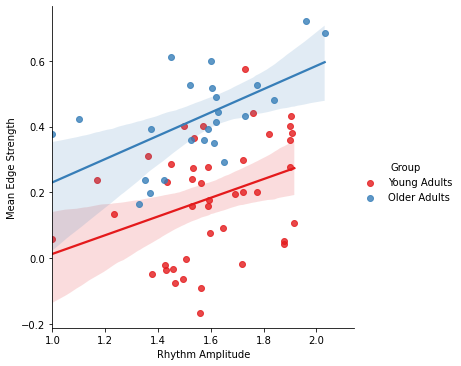

In [238]:
regdf = regdf[regdf['actamp'].abs() < 3]
regVars = ['actamp', 'pc_global_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))


sns.lmplot(data=regdf, x='actamp', y='net1_mean', hue='Group')
#           scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Mean Edge Strength')
plt.savefig('./results/amp_net1mean.png', dpi=300)

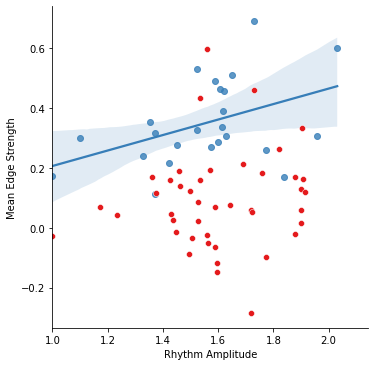

In [239]:
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='actamp', y='net2_mean', scatter_kws={'color': sns.color_palette('Set1')[1]}, line_kws={'color': sns.color_palette('Set1')[1]})
sns.scatterplot(data=df[df['Group'] == 'Young Adults'], x='actamp', y='net2_mean', color =sns.color_palette('Set1')[0])
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Mean Edge Strength')
plt.savefig('./results/amp_net2mean.png', dpi=300)

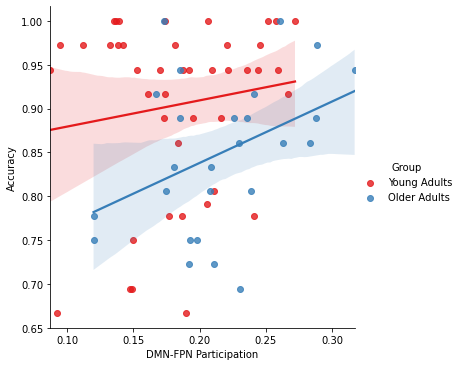

In [242]:
sns.lmplot(data=df, x='pc_dmnfpn_cue', y='acc_test_mean', hue='Group')
#           scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('DMN-FPN Participation'); plt.ylabel('Accuracy')
plt.savefig('./results/pcdmnfpncue_acc.png', dpi=300)

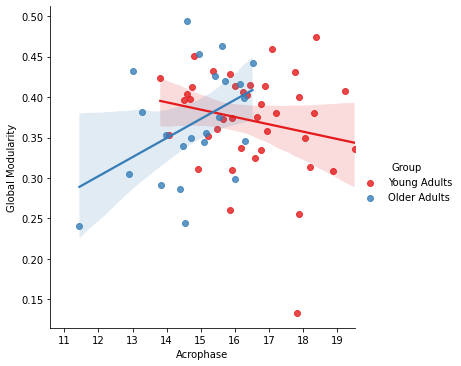

In [244]:
sns.lmplot(data=df, x='actphi', y='q_global_rest', hue='Group')
#           scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('Acrophase'); plt.ylabel('Global Modularity')
plt.savefig('./results/phi_qglobalrest.png', dpi=300)

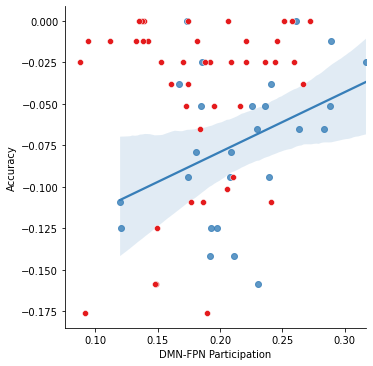

In [243]:
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='pc_dmnfpn_cue', y='acc_test_mean_log', scatter_kws={'color': sns.color_palette('Set1')[1]}, line_kws={'color': sns.color_palette('Set1')[1]})
sns.scatterplot(data=df[df['Group'] == 'Young Adults'], x='pc_dmnfpn_cue', y='acc_test_mean_log', color =sns.color_palette('Set1')[0])
plt.xlabel('DMN-FPN Participation'); plt.ylabel('Accuracy')
plt.savefig('./results/pcdmnfpncue_acc.png', dpi=300)

In [122]:
regVars = ['q_global_rest', 'actamp']

regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf = regdf[regdf['q_global_rest'].abs() < 3]

smf.ols(formula='q_global_rest ~ actamp', data=regdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          q_global_rest   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.801
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.185
Time:                        13:19:54   Log-Likelihood:                -77.953
No. Observations:                  61   AIC:                             159.9
Df Residuals:                      59   BIC:                             164.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0587      0.113      0.519      0.605      -0.168       0.285
actamp        -0.1528      0.114     -1.342      0.185      -0.381       0.075
==============================================================================
Omnibus:                        1.904   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.386   Jarque-Bera (JB):                1.716
Skew:                          -0.404   Prob(JB):                        0.424
Kurtosis:                       2.850   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [123]:
regVars = ['hc_fpn_fc', 'acc_test_mean_log']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='acc_test_mean_log ~ Group * hc_fpn_fc', data=regdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     3.476
Date:                Sun, 06 Mar 2022   Prob (F-statistic):             0.0209
Time:                        13:19:54   Log-Likelihood:                -92.774
No. Observations:                  69   AIC:                             193.5
Df Residuals:                      65   BIC:                             202.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.4885      0.205     -2.382      0.020      -0.898      -0.079
Group[T.Young Adults]               0.6350      0.255      2.493      0.015       0.126       1.144
hc_fpn_fc                           0.3768      0.197      1.914      0.060      -0.016       0.770
Group[T.Young Adults]:hc_fpn_fc    -0.5850      0.251     -2.334      0.023      -1.086      -0.084
==============================================================================
Omnibus:                       11.642   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.413
Skew:                          -1.025   Prob(JB):                      0.00202
Kurtosis:                       3.342   Cond. No.                         3.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Old Plot Code

In [124]:
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from scipy.stats.mstats import zscore

# testvar = 'hc_fpn_fc:Group[T.Young Adults]'
# plot_title = 'HC-FPN FC'
# x_pos = .5
# y_pos = -3.4

# model = smf.ols(formula='acc_test_mean_log ~ hc_fpn_fc * Group', data=df[abs(df['hc_fpn_fc']) < 3]).fit()
# summary = model.summary()

# #df = df.drop('40750')
# plt.figure(figsize=(8, 6), dpi=300)
# sns.lmplot(data=df[abs(df['hc_fpn_fc']) < 3], x='hc_fpn_fc', y="acc_test_mean_log", hue='Group', palette = 'Set1', legend_out=False)
# plt.ylabel('log(Accuracy)'); plt.xlabel('Mean HC-DMN FC')

# if model.pvalues[testvar] < 0.001:
#     plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
#     print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
# else:
#     plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
#     print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

# # plt.title('Paracingulate Gyrus - Frontal Orbital Cortex')
# plt.savefig(results_dir + 'scatter-hc-dmn-fc_accuracy.png', dpi=300, bbox_inches="tight")

# summary